# ROMY - Barometer

In [1]:
import os
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np

from src.baroseis import baroseis

## 1. Set Configurations

In [2]:
# Configuration dictionary
config = {

    # station parameters
    'station_latitude': 48.162941,
    'station_longitude': 11.275501,
    'station_elevation': 560.0,

    # set time window
    'time_buffer': 3600.0,  # Time buffer in seconds

    # processing parameters
    'sampling_rate': 1.0,  # Sampling rate of common stream in Hz

    # channel configurations
    # 'baro_seed': "BW.FFBI.30.BDO",
    'baro_seed': "BW.FFBI..BDO",
    'seis_seeds': ["BW.ROMY.40.BJZ", "BW.ROMY.40.BJN", "BW.ROMY.40.BJE"],
    # 'seis_seeds': ["BW.ROMY.00.BJZ", "BW.ROMY.00.BJN", "BW.ROMY.00.BJE"],
    # 'seis_seeds': ["BW.DROMY..HHZ", "BW.DROMY..HHN", "BW.DROMY..HHE"],
    # 'seis_seeds': ["GR.FUR..HHZ", "GR.FUR..HHN", "GR.FUR..HHE"],

    # path to station metadata
    'baro_inventory': "./metadata/station_BW_FFBI.xml",
    'seis_inventory': "./metadata/station_BW_ROMY.xml",
    # 'seis_inventory': "./metadata/station_BW_DROMY.xml",
    # 'seis_inventory': "./metadata/station_GR_FUR.xml",

    # data source
    'data_source': 'sds',  # 'sds' or 'mseed_file' or 'mseed_online'

    # path to data archive
    'path_to_baro_data': "/home/andbro/bay200/mseed_online/archive/",
    # 'path_to_baro_data': "/home/andbro/freenas/temp_archive/",
    'path_to_seis_data': "/home/andbro/freenas/temp_archive/",
    # 'path_to_seis_data': "/home/andbro/freenas/romy_archive/",
    # 'path_to_seis_data': "/home/andbro/bay200/mseed_online/archive/",

    # path to output
    'path_to_figures': './figures',

    # metadata correction
    'metadata_correction': True,

    # remove baro response
    'remove_baro_response': True,
    'pre_filter': (5e-5, 1e-4, 1e0, 2e0),

    # remove seis sensitivity
    'remove_seis_sensitivity': False,

    # remove seis response
    'remove_seis_response': True,

    # verbosity
    'verbose': True,
}



## 2. Initalize and Load Data

In [3]:
# Initialize baroseis object
bs = baroseis(conf=config)

In [4]:
# Can also override time window


# good event
# bs.load_data(
#     tbeg="2024-04-23 02:00",
#     tend="2024-04-23 05:00",
# )

# good event
# bs.load_data(
#     tbeg="2024-03-15 15:00",
#     tend="2024-03-15 18:00",
# )

# good event
# bs.load_data(
#     tbeg="2024-03-24 15:00",
#     tend="2024-03-24 17:00",
# )

# ?
bs.load_data(
    tbeg="2024-03-12 09:00",
    tend="2024-03-12 18:00",
)


# ------------------------------------------------------------
# bad event
# bs.load_data(
#     tbeg="2025-02-20 07:00",
#     tend="2025-02-20 10:00",
# )

# okey event
# bs.load_data(
#     tbeg="2025-02-20 07:00",
#     tend="2025-02-20 10:00",
# )


Loading data from SDS archive...


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.


 >scaling FFBI.BDO barometer data by 1e2 (hPa -> Pa)
Creating new Hilbert transform data...

>Runtime: 0.71 minutes



In [5]:
bs.st_baro_hilbert

1 Trace(s) in Stream:
BW.FFBI..BDH | 2024-03-12T08:00:00.005000Z - 2024-03-12T19:00:00.005000Z | 40.0 Hz, 1584001 samples

In [6]:
def compute_hilbert_stream(bs):
    """
    Compute Hilbert transform for the data streams.
    """
    from obspy.signal.filter import hilbert
    bdh = bs.st_baro.copy()
    if len(bdh) == 0:
        raise ValueError("No data found for channel *DO in stream")
    if len(bdh) == 1:
        for tr in bdh:
            tr.data = hilbert(tr.data)
            tr.stats.standard = 'Hilbert'
            tr.stats.channel = tr.stats.channel[:-1] + "H"
            return bdh
    else:
        raise ValueError("Multiple data found for channel *DO in stream. Aborting...")
    return bdh

In [7]:
bdh = compute_hilbert_stream(bs)

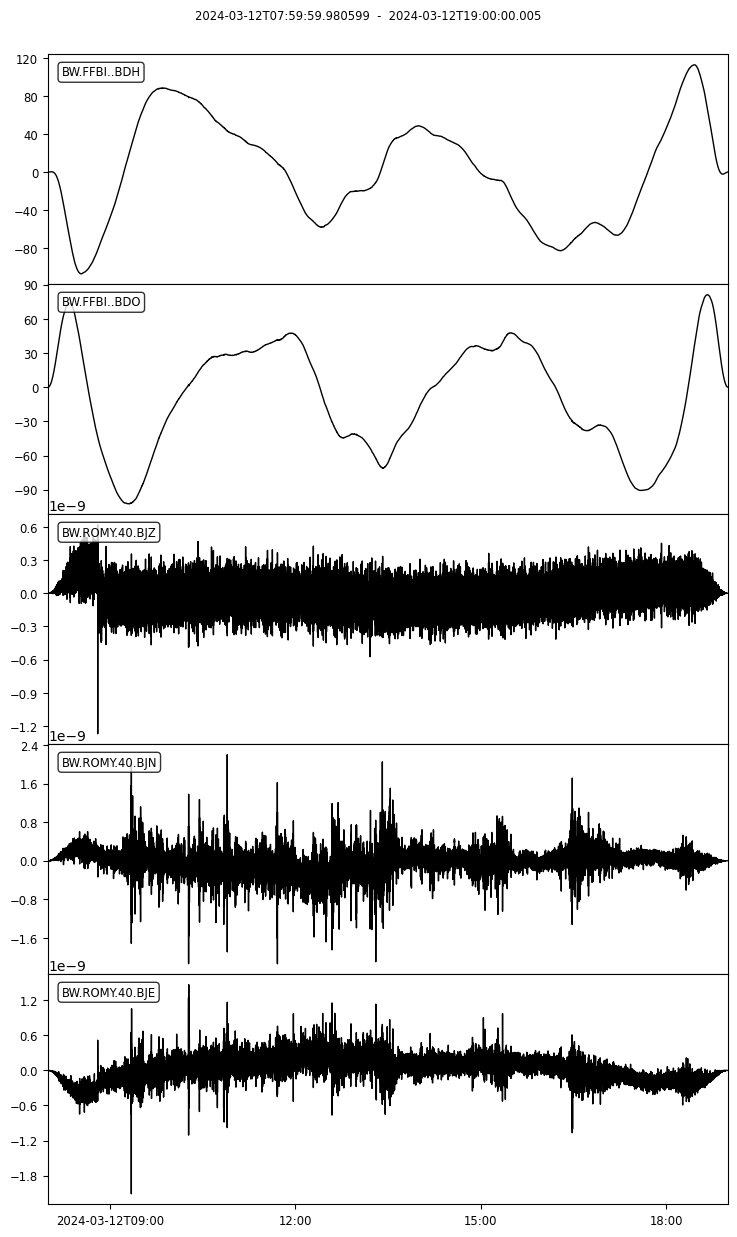

In [8]:
bs.st.plot(equal_scale=False);

## 3. Write Waveforms to File

In [9]:
file_postfix = f"{config['baro_seed'].split('.')[1]}_"
file_postfix += f"{config['seis_seeds'][0].split('.')[1]}_"
file_postfix += f"{bs.config['tbeg'].strftime('%Y%m%d')}"

In [10]:
# write waveforms to file
datapath = "./data/"
filename = f"{file_postfix}.mseed"

bs.st.write(os.path.join(datapath, filename), format="MSEED")



/home/andbro/.local/lib/python3.10/site-packages/obspy/io/mseed/core.py:773: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


## 4. Write Config to File

In [11]:
config = bs.config.copy()

# convert tbeg and tend to strings
config['tbeg'] = str(config['tbeg'])
config['tend'] = str(config['tend'])
config['t1'] = str(config['t1'])
config['t2'] = str(config['t2'])

baroseis.store_as_yaml(config, f"./data/config_{file_postfix}_sds.yaml")

# modify configuration settings for loading from file
config['data_source'] = 'file'
config['path_to_baro_data'] = f"./data/{file_postfix}.mseed"
config['path_to_seis_data'] = f"./data/{file_postfix}.mseed"

# update parameters for loading from file
config['metadata_correction'] = False
config['remove_baro_response'] = False
config['remove_seis_sensitivity'] = False
config['remove_seis_response'] = False
config['pre_filter'] = list(config['pre_filter'])

baroseis.store_as_yaml(config, f"./data/config_{file_postfix}_file.yaml")
